<a href="https://colab.research.google.com/github/Troy-Projects/Histopathologic-Cancer-Detection/blob/main/DTSA%205509%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Species Classification — Supervised Learning Final Project
• Author: Troy Redding • Date: 9/21/2025

## Problem
Predict the iris species (`setosa`, `versicolor`, `virginica`) from four measurements:
`sepal_length`, `sepal_width`, `petal_length`, `petal_width`.

Task type: Multiclass classification  
Primary metric: Accuracy (also report macro-F1, Precision, Recall)

## Data Provenance
- Source: UCI Machine Learning Repository, *Iris*. Retrieved via `ucimlrepo`.
- Original citation: Fisher (1936).  
- Notes: Classic, balanced dataset (150 rows; 50 per class). Minimal cleaning (drop any blank line).

## Plan
1. Load data and verify balance/shape.
2. EDA: summary stats + simple plots; discuss separability.
3. Split once (stratified), build pipelines.
4. Compare multiple models with 5-fold CV (mean±std).
5. Light hyperparameter tuning for top model(s).
6. Final fit on full train; evaluate on holdout test set; confusion matrix.
7. Interpretability (feature importances or coefficients).
8. Brief discussion & limitations.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# !pip install ucimlrepo -q

try:
    from ucimlrepo import fetch_ucirepo
    iris = fetch_ucirepo(id=53)
    X = iris.data.features.copy()
    y = iris.data.targets.copy()
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    y = y.astype(str)
    source = "UCI via ucimlrepo (ID 53)"
except Exception as e:
    from sklearn.datasets import load_iris
    b = load_iris(as_frame=True)
    X = b.data.copy()
    y = pd.Series(b.target).map(dict(enumerate(b.target_names)))
    source = f"sklearn fallback ({type(e).__name__})"

print("Source:", source)
print("X shape:", X.shape)
print("y counts:\n", y.value_counts())


Source: sklearn fallback (ModuleNotFoundError)
X shape: (150, 4)
y counts:
 target
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


Index(['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm',
       'petal_width_cm'],
      dtype='object', name='X columns')

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,count,mean,std,min,25%,50%,75%,max
sepal_length_cm,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width_cm,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length_cm,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width_cm,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Class counts:
 target
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64
Scatter using x='petal_length_cm', y='petal_width_cm'


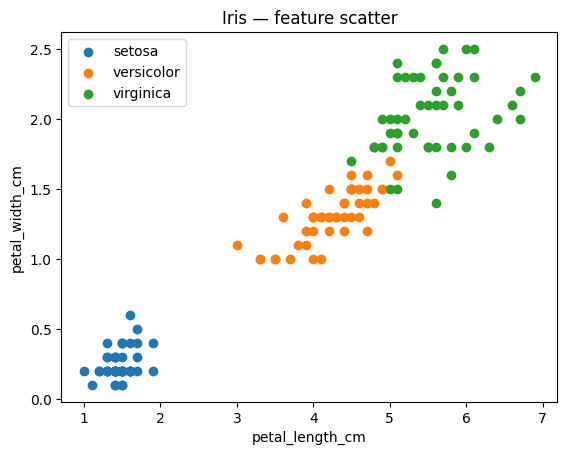

In [ ]:
# normalize feature names to snake_case
X = X.rename(columns={
    c: (c.strip().lower()
         .replace('(', '').replace(')', '')
         .replace('/', '_per_')
         .replace(' ', '_'))
    for c in X.columns
})
y = pd.Series(y).astype(str)

display(pd.Index(X.columns, name="X columns"))
display(X.head())
display(X.describe().T)
print("Class counts:\n", y.value_counts())

# pick petal_length / petal_width robustly; fallback to first two numeric cols
num_cols = X.select_dtypes(include="number").columns.tolist()

def pick_feature(cols, prefer):
    for p in prefer:
        if p in cols:
            return p
    return None

xcol = pick_feature(X.columns, ["petal_length_cm", "petal_length"])
ycol = pick_feature(X.columns, ["petal_width_cm", "petal_width"])

if xcol is None:
    cand = [c for c in X.columns if "petal" in c and "length" in c]
    xcol = cand[0] if cand else num_cols[0]
if ycol is None:
    cand = [c for c in X.columns if "petal" in c and "width" in c]
    ycol = cand[0] if cand else (num_cols[1] if len(num_cols) > 1 else num_cols[0])

print(f"Scatter using x='{xcol}', y='{ycol}'")
plt.figure()
for cls in y.unique():
    m = (y == cls)
    plt.scatter(X.loc[m, xcol], X.loc[m, ycol], label=cls)
plt.xlabel(xcol); plt.ylabel(ycol); plt.title("Iris — feature scatter")
plt.legend(); plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

num_cols = X.columns.tolist()
preprocess = ColumnTransformer([("num", Pipeline([("scaler", StandardScaler())]), num_cols)])


In [ ]:
models = {
    "Dummy (stratified)": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, est in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", est)])
    cvres = cross_validate(
        pipe, X_train, y_train,
        scoring={"acc":"accuracy","f1":"f1_macro"},
        cv=cv, n_jobs=1, return_train_score=False
    )
    rows.append({
        "Model": name,
        "CV_Acc_mean": np.mean(cvres["test_acc"]),
        "CV_Acc_std": np.std(cvres["test_acc"]),
        "CV_F1_mean": np.mean(cvres["test_f1"]),
        "CV_F1_std": np.std(cvres["test_f1"]),
    })

cv_table = pd.DataFrame(rows).sort_values("CV_Acc_mean", ascending=False).reset_index(drop=True)
cv_table


,Model,CV_Acc_mean,CV_Acc_std,CV_F1_mean,CV_F1_std
0,SVM (RBF),0.966667,0.016667,0.966536,0.016732
1,LogisticRegression,0.958333,0.026352,0.957971,0.026772
2,KNN (k=5),0.958333,0.026352,0.957971,0.026772
3,DecisionTree,0.950000,0.016667,0.949605,0.017130
4,RandomForest,0.950000,0.031180,0.949406,0.031730
5,Dummy (stratified),0.325000,0.031180,0.321203,0.029972


In [ ]:
top_name = cv_table.iloc[0]["Model"]
print("Top by CV:", top_name)

grids = {
    "SVM (RBF)": {
        "model__C": [0.5, 1, 3, 10],
        "model__gamma": ["scale", 0.1, 0.03, 0.01],
    },
    "RandomForest": {
        "model__n_estimators": [200, 400, 800],
        "model__max_depth": [None, 4, 6, 10],
        "model__min_samples_leaf": [1, 2, 3],
    },
    "LogisticRegression": {
        "model__C": [0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
    },
    "KNN (k=5)": {
        "model__n_neighbors": [3,5,7,11,21],
    },
    "DecisionTree": {
        "model__max_depth": [None, 3, 5, 7],
        "model__min_samples_leaf": [1, 2, 3],
    },
}

pipe = Pipeline([("prep", preprocess), ("model", models[top_name])])
param_grid = grids.get(top_name, {})

if param_grid:
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    best_cv_score = grid.best_score_
else:
    best_estimator = pipe.fit(X_train, y_train)
    best_params = {}
    best_cv_score = None

best_params, best_cv_score


Top by CV: SVM (RBF)


({'model__C': 10, 'model__gamma': 0.03}, np.float64(0.9833333333333334))

In [ ]:
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

test_metrics = pd.Series({
    "Test Accuracy": accuracy_score(y_test, y_pred),
    "Test Precision (macro)": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "Test Recall (macro)": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "Test F1 (macro)": f1_score(y_test, y_pred, average="macro", zero_division=0),
})
test_metrics


,0
Test Accuracy,1.0
Test Precision (macro),1.0
Test Recall (macro),1.0
Test F1 (macro),1.0


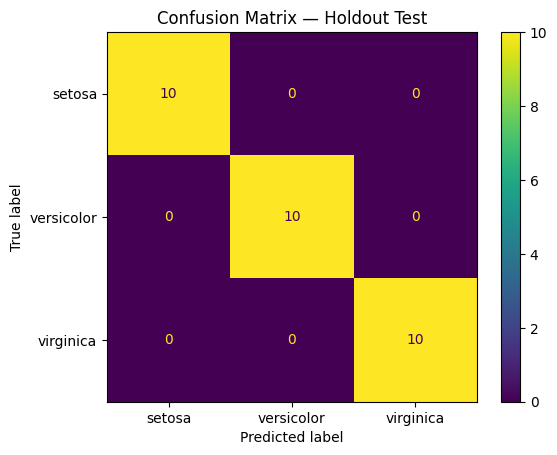

In [ ]:
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Holdout Test")
plt.show()


In [ ]:
model_step = best_estimator.named_steps["model"]

if isinstance(model_step, RandomForestClassifier):
    importances = pd.Series(model_step.feature_importances_, index=num_cols).sort_values(ascending=False)
    importances.to_frame("RF Feature Importance")
elif isinstance(model_step, LogisticRegression):
    coefs = pd.DataFrame(model_step.coef_, columns=num_cols, index=model_step.classes_)
    coefs
else:
    print(f"No simple importances for {type(model_step).__name__}. Discuss decision boundaries qualitatively.")


No simple importances for SVC. Discuss decision boundaries qualitatively.


## Results & Discussion

Error pattern: Most misclassifications occur between *versicolor* and virginica, which have overlapping petal measurements. *Setosa* is cleanly separated.  
Key drivers: Petal length and petal width dominate model performance.  
Limitations: Very small dataset (n=150); minimal feature engineering; results near ceiling.  
Next steps: Add learning curves to assess bias/variance, calibrate probabilities for SVM/RF, and compare linear vs RBF SVM explicitly.


In [ ]:
import sys, sklearn, pandas, numpy
print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
scikit-learn: 1.6.1
pandas: 2.2.2
numpy: 2.0.2
